In [1]:
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 

# Instance-based Counterfactual Explanations for Time Series Classification


## Dataset Name

In [2]:
dataset='ElectricDevices'

## Load Data and Data Preparation
Download Data from here: https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/.
Set cwd to the data folder.

In [3]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])

In [4]:
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
pickle.dump(enc1,open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [5]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

# Explanations Algorithm

In [6]:
item=test_x[10].reshape(1,1,-1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


In [7]:
print(y_target)

[[3.2852639e-24 3.9285800e-13 3.3342823e-28 8.9749534e-05 9.9946076e-01
  4.3696380e-04 1.2602746e-05]]


In [8]:
from TSInterpret.InterpretabilityModels.counterfactual.NativeGuideCF import NativeGuideCF
exp_model=NativeGuideCF(model,shape,(train_x,train_y), backend='PYT', mode='feat',method='dtw_bary_center')

2022-07-06 12:07:34.796684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 12:07:34.796700: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
exp,label=exp_model.explain(item, np.argmax(y_target,axis=1))

# Plot Item 

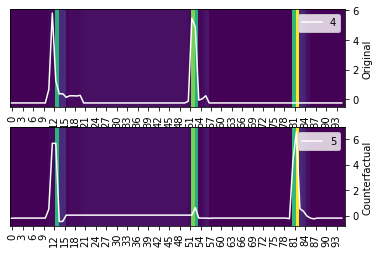

In [10]:

exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

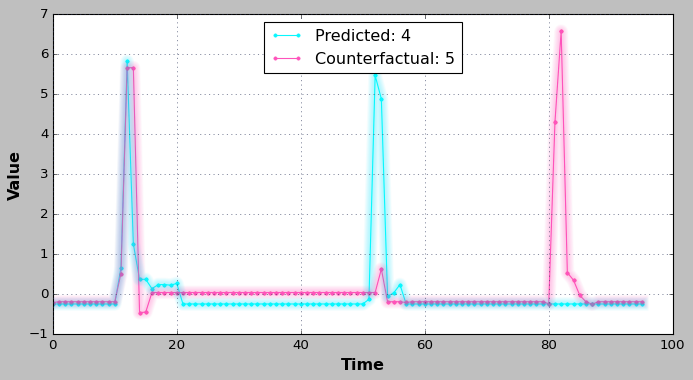

In [11]:
exp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)